# Residential Real Estate Analysis: King County House Sales

## Luke DiPerna

### October 2022

## Project Goal
***
This project is designed to assist a residential real estate company operating in King County. The company primarily helps homeowners sell their home. The company needs a reliable and efficient way to properly valuate their clients houses. For this to be feasible, they will need to know what features are most important in determining current market value, and be able to easily communicate this to their clients as they set a selling price. In addition, they want to be able to offer suggestions for how a homeowner can improve the valuation of their home.

Using the data provided by the company, I will build a linear regression model that can assist them in setting a selling price, as well as identifying the key features when determining the price.

## Table of Contents


## Data Preparation
***
The data for this project is the King County house sales dataset. It contains 21,596 house sales in the county in 2014 and 2015. This project assumes that that data is current, and as a result does not take inflation into account.

The dataset is relatively clean, with few null values and errors, but still requires some attention before linear regression can be performed.

In [142]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from yellowbrick.regressor import ResidualsPlot

### Data Overview

In [2]:
house_df = pd.read_csv('data/kc_house_data.csv')
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

There are four features with some null values (`waterfront`, `view`, `yr_built`, and `yr_renovated`). Additionally, some of the features, like condition and grade, will likely be more useful as either `int64` or `category` dtypes, so I will need to examine some of the `object` features

### Data Clean Up

I do not need the exact date of each sale, but I do want to know the age of each house at the time of sale, so I will create a `house_age` feature. In addition, since so few houses have been renovated, I will bin the renovation data by creating a boolean feature `renovated` to indicate if the house has been renovated or not.

In [4]:
# create yr_sold and use to calculate house_age
house_df['yr_sold'] = house_df['date'].str[-4:].astype('int64')
house_df['house_age'] = house_df['yr_sold'] - house_df['yr_built']

# some houses appear to have been sold before they were finished building,
# so this sets house age to 0 instead of -1
house_df['house_age'][house_df['house_age'] == -1] = 0

#create renovated category
conditional = (
    (house_df['yr_renovated']==0) |
    (house_df['yr_renovated'].isna())
    )
house_df['renovated'] = np.where(conditional, 0, 1)
house_df['renovated'].astype('category')

house_df['grade'] = house_df['grade'].str.strip(string.ascii_letters+string.whitespace).astype('int64')

<ipython-input-4-0e6d4dff9394>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['house_age'][house_df['house_age'] == -1] = 0


In [5]:
house_df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [6]:
house_df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Since NONE is the most common value for `view`, and NO is the most common value for `waterfront`, I will use those values to fill the null fields.

In [7]:
house_df['view'].fillna('NONE', inplace=True)
house_df['waterfront'].fillna('NO', inplace=True)

The `waterfront`, `condition`, and `view` columns are all categorical, but I also want to examine them as numeric values since they are ordinal. First I will attempt regression with the values as numeric, and then later as categorical.

In [8]:
# change the columns to numeric
house_df['waterfront'].replace({'NO': 0, 'YES': 1}, inplace=True)

cnd_rpl = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
house_df['condition'].replace(cnd_rpl, inplace=True)

view_rpl = {'NONE': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
house_df['view'].replace(view_rpl, inplace=True)

In [9]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Now the data is almost ready. I will drop some unnecessary columns, then build the preliminary model. `sqft_basement` has some errors and would require more cleaning before it could be used, but the feature does not correlate well with price and is highly colinear with other features such as `sqft_above`, so it will be dropped. In addition, I no longer need the `yr_sold` or `yr_built` column now that I have `house_age`, so it will be dropped as well. I will also drop `yr_renovated`, which has been replaced with the `renovated` column. Lastly, the `date` and `id` columns cannot be used, so they will be dropped. 

In [10]:
house_df.drop(['yr_sold', 'date', 'id', 'sqft_basement', 'yr_renovated', 'yr_built'], axis=1, inplace=True)

## Regression Models:
***
I will begin by building a simple linear regression model using features that correlate highly with `price`. This will be my baseline. From there, I will build more complex models using additional features/methods to refine the model and increase accuracy.

In order to compare the models, I will be using the following metrics:

- **R-squared**: measures goodness-of-fit for the model. The score (ranging between 0-1) naturally increases as the number of variables in the model increases, so we will also need the adjusted score.
- **Cross-Validation Score**: the mean of the model's R-squared scores when performed 10 times on different splits of the data.
- **Adjusted R-squared**: accounts for the number of features included in the model. This score will drop relative to the unadjusted score if the additional features do not improve the model.
- **Root Mean Squared Error**: measures the amount of error in the model.

First I need to create a function to calculate the adjusted R-squared score, and then a function to collect all the metrics together.

In [11]:
def adjustedR2(r2,n,k):
    '''
    Will use the R-squared score, n number of observations, and k number of variables in the model
    to create an adjusted R-squared score for the model.
    -
    Inputs:  
    r2 = the R-squared score for the model
    n = the number of observations in the data
    k = the number of variables (features) used in the model.
    -
    Output:
    Adjusted R-squared
    '''
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [12]:
def eval_model(X, y, X_train, X_test, y_train, y_test):
    
    '''
    Will take the data and create a linear regression model using the sklearn LinearRegression() class.
    
    -
    Inputs:
    
    X = the dataframe with the independent variables (seperated by column) for all observations.
    y = the dataframe with only the dependent variable for all observations.
    X_train = the X data used as the training set. Will be used to fit the model.
    X_test = the X data used as the test set. Will be used to test the model.
    y_train = the y data for the training set.
    y_test = the y data for the test set.
    
    -
    Output:
    Will display the key metrics used to evaluate the model.
    
    '''
    
    lr = LinearRegression()
    model = lr.fit(X_train, y_train)
    
    trainR2 = model.score(X_train, y_train)
    testR2 = model.score(X_test, y_test)
    
    train_pred = lr.predict(X_train)
    test_pred = lr.predict(X_test)
    
    return print(
f''' Intercept: {model.intercept_}
Coefficient: {model.coef_}

Train R2: {trainR2}
Train Adjusted R2: {adjustedR2(trainR2, len(y), X.shape[1])}
Train RMSE: {mean_squared_error(y_true=y_train, y_pred=train_pred, squared=False)}

Train Cross-Validation: {cross_val_score(model, X_train, y_train, cv=10).mean()}

Test R2: {testR2}
Test Adjusted R2: {adjustedR2(testR2, len(y), X.shape[1])}
Test RMSE: {mean_squared_error(y_true=y_test, y_pred=test_pred, squared=False)}
'''
)

### Preliminary Model:

For a baseline, I will create a regression model using only 2 variables. They will be the variables with the highest correlation to our dependent variable, `price`.

In [13]:
# sort the variables by correlation to price
house_df.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
renovated        0.117543
sqft_lot         0.089876
sqft_lot15       0.082845
house_age        0.053896
zipcode          0.053402
condition        0.036056
long             0.022036
Name: price, dtype: float64

`sqft_living` and `grade` seem to be the 2 most correlated features, so I will use them to create the first model. To do this, I will declare the `X` (independent variables) and `y` (dependent variable) and split them into a train and test set. I can them create and evaluate the model using the function `eval_model` I created above.

In [14]:
X = house_df[['sqft_living', 'grade']]
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [15]:
eval_model(X, y, X_train, X_test, y_train, y_test)

 Intercept: -592490.8978219961
Coefficient: [  181.1519458  98707.31697338]

Train R2: 0.5326350103958808
Train Adjusted R2: 0.5325917238357618
Train RMSE: 247902.3792287786

Train Cross-Validation: 0.5314689386442116

Test R2: 0.5400070055101824
Test Adjusted R2: 0.5399644017318653
Test RMSE: 258553.27836440195



The model has an R-squared score of around 53% for both the train and test sets. This is nowhere near useful enough, as seen by the Test Root-Mean-Squared-Error, which indicates that the model's predictions are, on average, off by about $258,553. Still, it is a useful starting point.

Another thing to note is that since there were only 2 variables, it is unsurprising that the adjusted R-squared values are very close to the unadjusted scores.

### 1st Iteration: All Variables

By looking at the `price` correlation values from earlier, it would seem that some variables may not be useful for predicting selling price. Additionally, based on the features available, it appears that some of them may show strong co-linearity.

Before I examine these issues, however, I want to create a model based on all available variables and see how the scores compare. In theory, the extra variables could make the model more accurate at the cost of interpretability, since co-linear features will make it much more difficult to determine the impact that each independent feature is exerting on the model. Alternatively, the extra features could make the adjusted R-squared scores much lower than the unadjusted scores, if the extra features are not significantly contributing to the model.

In [16]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [17]:
eval_model(X, y, X_train, X_test, y_train, y_test)

 Intercept: 491444.0637777564
Coefficient: [-3.21647396e+04  3.83429122e+04  1.45432163e+02  8.96251437e-02
  8.29526895e+03  6.40367356e+05  5.64804926e+04  2.65356760e+04
  9.78286934e+04  2.73654489e+01 -5.77116305e+02  6.05776297e+05
 -2.16263622e+05  2.50231890e+01 -3.46334374e-01  2.57671996e+03
  5.28525631e+04]

Train R2: 0.6997887434622276
Train Adjusted R2: 0.6995522361467291
Train RMSE: 198685.46309385466

Train Cross-Validation: 0.6974007087573947

Test R2: 0.7005626421761069
Test Adjusted R2: 0.7003267445403032
Test RMSE: 208606.30522241787



The R-squared score has improved significantly from the preliminary model, jumping from 53% to around 70%. Surprisingly, the adjusted R-squared scores are very close to the unadjusted scores, which indicates that the extra features helped improve the model, even though many features had a low correlation with `price`. The similarity of the train and test scores also indicates that the model is not suffering from overfitting.

Overall, this is already a large improvement over the baseline model. Since the primary goal for the stakeholder is an accurate model, it makes since to use all available features since the adjusted R-squared score does not suffer and co-linearity is less of a concern.

### 2nd Iteration: Normalization/Standardization

While not always necessary for linear regression models, it can sometimes help to normalize and standardize the data before fitting a model. Since much of the data is heavily skewed, I will try to normalize and standardize to see if model performance improves.

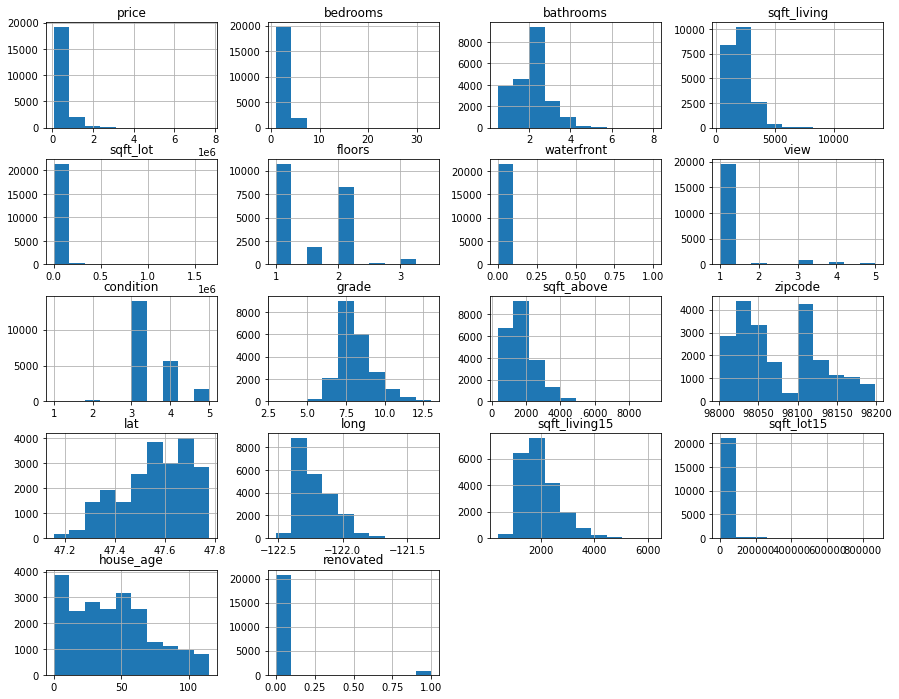

In [18]:
house_df.hist(figsize=(15,12));

Looking at the feature histograms shows that several of them are heavily skewed and non-normal. I will leave the categorical variables and focus on the continuous variables: `sqft_lot`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_living15`, and `sqft_lot15`.

In [19]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [20]:
# create dataframes of the train and test data that will be transformed
trans_features = ['sqft_lot', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
trans_train = X_train[trans_features]
trans_test = X_test[trans_features]

# will standarize and normalize the data
pt = PowerTransformer()

# transform the train data and replace with the untransformed data
trans_X_train = pt.fit_transform(trans_train)
tx_train = pd.DataFrame(trans_X_train, index=trans_train.index, columns=trans_features)
X_train.drop(trans_features, axis=1, inplace=True)
X_train = pd.concat([X_train, tx_train], axis=1)

# transform the test data and replace with the untransformed data
trans_X_test = pt.fit_transform(trans_test)
tx_test = pd.DataFrame(trans_X_test, index=trans_test.index, columns=trans_features)
X_test.drop(trans_features, axis=1, inplace=True)
X_test = pd.concat([X_test, tx_test], axis=1)

eval_model(X, y, X_train, X_test, y_train, y_test)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


 Intercept: 10091388.713545684
Coefficient: [-1.39741292e+04  8.07631915e+04  2.49283391e+03  6.86625966e+05
  6.51531547e+04  2.26030374e+04  1.40149408e+05 -5.66313172e+02
  5.90288042e+05 -1.34326523e+05  3.15812950e+03  4.39270525e+04
  2.60994058e+03  5.40797916e+04  2.60994058e+03  8.57675911e+03
  1.74945353e+04 -1.09894165e+04]

Train R2: 0.6628319693082866
Train Adjusted R2: 0.6625663473368439
Train RMSE: 210559.96584067744

Train Cross-Validation: 0.6615601522799205

Test R2: 0.654828881222317
Test Adjusted R2: 0.6545569543944185
Test RMSE: 223970.93608870124



The R-squared scores for the transformed model are around 65%-66%. This is an improvement over the baseline model scores of around 50%, but is lower than the untransformed model, which is around 70%. This means that transforming the data in this way has actually hurt the model, even though the transformation was successful (see below). 

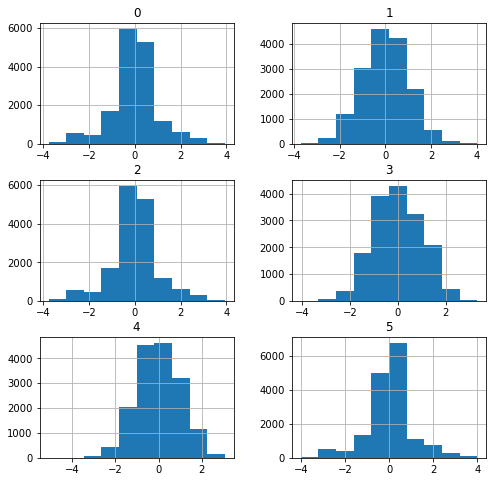

In [21]:
# display histograms of the transformed train data
pd.DataFrame(trans_X_train).hist(figsize=(8,8));

The transformed features are far more normalized than before, but this has failed to improve the model. This is often the case with linear regression models, where the true values can be useful to determining the relative weight of each variable and its relationship to the dependent variable.

### 3rd Iteration: Categorical Variables

The next step is to take the categorical features, which are currently being used as numeric values, and treat them as categorical for the purposes of the model. This will require one-hot-encoding the categorical features before creating the model.

Since the numeric values for many of the categorical features are small (for example, the values for `bathrooms` and `condition` are all between 0-10), and the other numeric variables like `sqft_living` are large (between 0-10,000), it is possible that the categorical variables are being under-represented in the previous models. One-hot-encoding will hopefully correct that, leading to a more accurate model.

In [22]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [23]:
# create train/test dataframes using only the categorical variables
cats = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
cats_train = X_train[cats].astype('category')
cats_test = X_test[cats].astype('category')

In [24]:
# create OHE train dataframe
ohe = OneHotEncoder(handle_unknown='ignore')
trans_train = ohe.fit_transform(cats_train).toarray()
# get_feature_names is deprecated. current: get_feature_names_out
column_names = ohe.get_feature_names(cats_train.columns)
ohe_train = pd.DataFrame(trans_train, index=cats_train.index, columns=column_names)
ohe_train

,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
21270,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7399,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1768,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9929,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3240,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that I have the OHE dataframe, I can use it to replace the categorical features in the original train dataframe.

In [25]:
X_train.drop(cats, axis=1, inplace=True)
X_train = pd.concat([X_train, ohe_train], axis=1)
X_train

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,sqft_lot,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,renovated,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
21270,1914,3272,1914,98055,47.4297,-122.189,1714,3250,5,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9198,1160,17700,1160,98133,47.7244,-122.331,1440,9000,68,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18939,1320,8625,1320,98056,47.4902,-122.179,1370,8295,57,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3188,1740,4200,1640,98117,47.6782,-122.361,1660,3750,94,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7399,2540,5612,2540,98059,47.4965,-122.157,2380,6303,15,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,1210,1278,1020,98117,47.6756,-122.375,1210,1118,7,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1768,4370,22863,3670,98033,47.6878,-122.215,2980,22863,107,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9929,3710,34200,2510,98074,47.6101,-122.047,1720,23100,28,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3240,1870,9825,1250,98045,47.4639,-121.744,1380,11475,20,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


I will repeat the process for the test set.

In [26]:
trans_test = ohe.transform(cats_test).toarray()
# get_feature_names is deprecated. current: get_feature_names_out
column_names = ohe.get_feature_names(cats_test.columns)
ohe_test = pd.DataFrame(trans_test, index=cats_test.index, columns=column_names)

X_test.drop(cats, axis=1, inplace=True)
X_test = pd.concat([X_test, ohe_test], axis=1)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
eval_model(X, y, X_train, X_test, y_train, y_test)

 Intercept: 7348197.798466224
Coefficient: [ 1.29401801e+02  1.11448707e-01 -1.00144640e+01 -5.91746889e+02
  6.08803243e+05 -1.86650892e+05  3.86422963e+01 -4.08271395e-01
  1.90064792e+03  8.12893002e+04  5.82744181e+04  7.49657700e+04
  5.33744589e+04  3.24299316e+04  2.83939154e+04 -3.74827188e+04
 -3.90000156e+04  9.58494085e+04 -7.58453949e+04 -1.44460578e+05
 -1.94166947e+05  1.47667751e+05 -3.97148685e+05 -3.42777708e+05
 -3.24503166e+05 -3.24441138e+05 -3.21971352e+05 -3.26279880e+05
 -3.16597602e+05 -3.10027984e+05 -3.21819421e+05 -3.16449869e+05
 -2.84926773e+05 -2.57801698e+05 -2.68806355e+05 -1.41307822e+05
 -1.76559524e+05 -7.83244949e+04 -1.30720570e+05  1.02193246e+05
  7.75833519e+04  2.00288374e+05  3.92065446e+05 -7.08117182e+05
  6.13601727e+05  1.25203370e+06 -4.89804146e+05 -5.06563044e+04
 -3.52798043e+05  3.60407387e+06 -7.06194357e+04 -5.00678033e+04
 -4.05131522e+04  6.13972364e+04 -6.93271452e+03  1.06735869e+05
 -2.74516575e+05  2.74516575e+05 -1.20953494e+0

One-hoe-encoding appears to have slightly improved upon the previous best model, with the R-squared score increasing from 70% to around 72%. The Train R-squared is actually 74%, but the cross-validation score indicates that is likely only because of the particular split used to create the train set, so the model does not appear to be suffering from over-fitting. Additionally, the extra variables that were created when performing one-hot-encoding do not appear to have diluted the results, as seen by the similarity of the adjusted and unadjusted R-squared scores. 

In [28]:
def make_ohe_X(X_train, X_test, cats):
    
    cats_train = X_train[cats].astype('category')
    cats_test = X_test[cats].astype('category')
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    trans_train = ohe.fit_transform(cats_train).toarray()
    # get_feature_names is deprecated. current: get_feature_names_out
    column_names = ohe.get_feature_names(cats_train.columns)
    ohe_train = pd.DataFrame(trans_train, index=cats_train.index, columns=column_names)    
    X_train.drop(cats, axis=1, inplace=True)
    X_train = pd.concat([X_train, ohe_train], axis=1)
    
    trans_test = ohe.transform(cats_test).toarray()
    # get_feature_names is deprecated. current: get_feature_names_out
    column_names = ohe.get_feature_names(cats_test.columns)
    ohe_test = pd.DataFrame(trans_test, index=cats_test.index, columns=column_names)    
    X_test.drop(cats, axis=1, inplace=True)
    X_test = pd.concat([X_test, ohe_test], axis=1)
    
    return X_train, X_test

### 4th Iteration: Polynomial Regression

The next step is to look for interactions between the variables. As noted earlier, there appeared to be some co-linearity between the variables. While this is not necessarily an issue when making a model based on accuracy, it suggests that there may be some interactions between the variables. If I am able to identify some useful interactions, they can help improve the model by providing additional useful features, at the cost of explainability.

Since I am not well-versed in real estate, I do not have the domain knowledge necessary to know what features are likely to have strong interactions ahead of time. Instead, I will examine all potential variable interactions and work backward from there. I will do this using polynomial regression, which will create a new variable for each feature pair by multiplying the 2 features together.

First, I will perform polynomial regression with the categorical variables remaining in their numeric form. Then I will attempt it again with the categorical variables one-hot-encoded.

In [29]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [30]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns))
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns))
poly_train

,1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 house_age,sqft_living15 renovated,sqft_lot15^2,sqft_lot15 house_age,sqft_lot15 renovated,house_age^2,house_age renovated,renovated^2
0,1.0,4.0,2.50,1914.0,3272.0,2.0,0.0,1.0,3.0,8.0,...,2937796.0,5570500.0,8570.0,0.0,10562500.0,16250.0,0.0,25.0,0.0,0.0
1,1.0,2.0,1.00,1160.0,17700.0,1.0,0.0,1.0,3.0,7.0,...,2073600.0,12960000.0,97920.0,0.0,81000000.0,612000.0,0.0,4624.0,0.0,0.0
2,1.0,3.0,1.00,1320.0,8625.0,1.0,0.0,1.0,4.0,7.0,...,1876900.0,11364150.0,78090.0,0.0,68807025.0,472815.0,0.0,3249.0,0.0,0.0
3,1.0,3.0,1.50,1740.0,4200.0,1.5,0.0,1.0,4.0,7.0,...,2755600.0,6225000.0,156040.0,0.0,14062500.0,352500.0,0.0,8836.0,0.0,0.0
4,1.0,3.0,2.50,2540.0,5612.0,2.0,0.0,1.0,3.0,9.0,...,5664400.0,15001140.0,35700.0,0.0,39727809.0,94545.0,0.0,225.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1.0,2.0,1.50,1210.0,1278.0,2.0,0.0,1.0,3.0,8.0,...,1464100.0,1352780.0,8470.0,0.0,1249924.0,7826.0,0.0,49.0,0.0,0.0
16193,1.0,4.0,2.25,4370.0,22863.0,2.5,0.0,4.0,4.0,10.0,...,8880400.0,68131740.0,318860.0,2980.0,522716769.0,2446341.0,22863.0,11449.0,107.0,1.0
16194,1.0,5.0,3.25,3710.0,34200.0,2.0,0.0,1.0,3.0,8.0,...,2958400.0,39732000.0,48160.0,0.0,533610000.0,646800.0,0.0,784.0,0.0,0.0
16195,1.0,3.0,2.50,1870.0,9825.0,1.0,0.0,1.0,4.0,7.0,...,1904400.0,15835500.0,27600.0,0.0,131675625.0,229500.0,0.0,400.0,0.0,0.0


As seen above, the polynomial regression has increased the number of variables from 17 to to 153 by multiplying each variable together to create a new variable.

In [31]:
eval_model(X, y, poly_train, poly_test, y_train, y_test)

 Intercept: 21288543316.33375
Coefficient: [ 7.93982862e-01  9.47421149e+06 -9.90300658e+06 -2.19504216e+04
  3.81273338e+01 -4.51542183e+07  1.26013406e+08 -2.71724295e+06
 -3.04432374e+06 -1.51346788e+07  5.53219054e+04 -4.50131371e+05
  8.78369242e+07  1.98854169e+07 -1.53491900e+04  3.62900438e+01
 -1.14294058e+05  4.11387393e+07  7.71082826e+02  1.14702052e+03
 -1.86012433e+01  4.59150224e-02  1.86103371e+04 -3.90194205e+04
  2.59227407e+03 -2.85458994e+03  1.58682267e+03  9.24706643e-01
 -1.18315743e+00 -3.00095179e+04  6.51942003e+04  6.01810763e+00
  1.79530888e-02  3.65842283e+02 -1.31403987e+04  2.63805531e+03
  1.95053214e-01 -3.45638332e-01 -3.07656749e+04  4.88379904e+04
 -7.17203144e+02 -1.22180549e+04  7.35084048e+03  2.16709010e+01
  1.87891294e+01  5.56093085e+04 -4.43493082e+04  2.72386550e+00
  7.71856738e-02 -1.81471939e+02 -5.17014487e+04 -4.12521278e-02
 -2.52259895e-04  2.71815874e+00 -9.50402768e+00 -1.92938941e+01
  2.08597364e+01  3.44193189e+01  8.57541997e-0

Polynomial regression has further improved upon the best model so far. Previously, the best model was the one-hot-encoded model, with an R-squared score of around 72%. The new model has an R-squared score of around 82%. The cross validation score is 80%, which indicates the R-squared score might be overly optimistic, but even the cross validation score is well above the previous best model. Additionally, the test R-squared score is also around 80%, so the model does not appear to be over-fit.

Next I will attempt polynomial regression with the one-hot-encoded variables included. Due to the exponential nature of polynomial regression, the additional variables may lead to a highly overfit model.

In [32]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)
cats = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

In [33]:
X_train, X_test = make_ohe_X(X_train, X_test, cats)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns))
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns))
poly_train

,1,sqft_living,sqft_lot,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,...,grade_10^2,grade_10 grade_11,grade_10 grade_12,grade_10 grade_13,grade_11^2,grade_11 grade_12,grade_11 grade_13,grade_12^2,grade_12 grade_13,grade_13^2
0,1.0,1914.0,3272.0,1914.0,98055.0,47.4297,-122.189,1714.0,3250.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1160.0,17700.0,1160.0,98133.0,47.7244,-122.331,1440.0,9000.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1320.0,8625.0,1320.0,98056.0,47.4902,-122.179,1370.0,8295.0,57.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1740.0,4200.0,1640.0,98117.0,47.6782,-122.361,1660.0,3750.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2540.0,5612.0,2540.0,98059.0,47.4965,-122.157,2380.0,6303.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1.0,1210.0,1278.0,1020.0,98117.0,47.6756,-122.375,1210.0,1118.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16193,1.0,4370.0,22863.0,3670.0,98033.0,47.6878,-122.215,2980.0,22863.0,107.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16194,1.0,3710.0,34200.0,2510.0,98074.0,47.6101,-122.047,1720.0,23100.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16195,1.0,1870.0,9825.0,1250.0,98045.0,47.4639,-121.744,1380.0,11475.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Instead of 153 columns, we now have over 3,000!

In [35]:
eval_model(X, y, poly_train, poly_test, y_train, y_test)

 Intercept: 33722897595.841278
Coefficient: [-5.79295064e+06  1.14913897e+05  1.48219848e+05 ... -1.68170862e+08
  0.00000000e+00 -4.73713341e-01]

Train R2: 0.8776186246945452
Train Adjusted R2: 0.8775222122852495
Train RMSE: 126855.78336299812

Train Cross-Validation: -11163.226425918596

Test R2: -36401.2830421151
Test Adjusted R2: -36429.960868321876
Test RMSE: 72734214.18639728



As expected, the OHE polynomial regression model is highly overfit. This is demonstrated by the fact that the train R-squared score is up to 86%, but the cross validation and test scores are negative.

I also attempted to improve upon the first polynomial regression model by increasing the degree to 3, but this had a similar effect: too many variables led to an over-fit and unusable model.

Now that we have a functional model, I will examine it more closely to ensure the results were not a result of random chance based on the train/test split.

### Model Validation

In [138]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,renovated
21270,4,2.50,1914,3272,2.0,0,1,3,8,1914,98055,47.4297,-122.189,1714,3250,5,0
9198,2,1.00,1160,17700,1.0,0,1,3,7,1160,98133,47.7244,-122.331,1440,9000,68,0
18939,3,1.00,1320,8625,1.0,0,1,4,7,1320,98056,47.4902,-122.179,1370,8295,57,0
3188,3,1.50,1740,4200,1.5,0,1,4,7,1640,98117,47.6782,-122.361,1660,3750,94,0
7399,3,2.50,2540,5612,2.0,0,1,3,9,2540,98059,47.4965,-122.157,2380,6303,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,2,1.50,1210,1278,2.0,0,1,3,8,1020,98117,47.6756,-122.375,1210,1118,7,0
1768,4,2.25,4370,22863,2.5,0,4,4,10,3670,98033,47.6878,-122.215,2980,22863,107,1
9929,5,3.25,3710,34200,2.0,0,1,3,8,2510,98074,47.6101,-122.047,1720,23100,28,0
3240,3,2.50,1870,9825,1.0,0,1,4,7,1250,98045,47.4639,-121.744,1380,11475,20,0


In [139]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns), index=X_train.index)
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns), index=X_test.index)
poly_train

,1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 house_age,sqft_living15 renovated,sqft_lot15^2,sqft_lot15 house_age,sqft_lot15 renovated,house_age^2,house_age renovated,renovated^2
21270,1.0,4.0,2.50,1914.0,3272.0,2.0,0.0,1.0,3.0,8.0,...,2937796.0,5570500.0,8570.0,0.0,10562500.0,16250.0,0.0,25.0,0.0,0.0
9198,1.0,2.0,1.00,1160.0,17700.0,1.0,0.0,1.0,3.0,7.0,...,2073600.0,12960000.0,97920.0,0.0,81000000.0,612000.0,0.0,4624.0,0.0,0.0
18939,1.0,3.0,1.00,1320.0,8625.0,1.0,0.0,1.0,4.0,7.0,...,1876900.0,11364150.0,78090.0,0.0,68807025.0,472815.0,0.0,3249.0,0.0,0.0
3188,1.0,3.0,1.50,1740.0,4200.0,1.5,0.0,1.0,4.0,7.0,...,2755600.0,6225000.0,156040.0,0.0,14062500.0,352500.0,0.0,8836.0,0.0,0.0
7399,1.0,3.0,2.50,2540.0,5612.0,2.0,0.0,1.0,3.0,9.0,...,5664400.0,15001140.0,35700.0,0.0,39727809.0,94545.0,0.0,225.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,1.0,2.0,1.50,1210.0,1278.0,2.0,0.0,1.0,3.0,8.0,...,1464100.0,1352780.0,8470.0,0.0,1249924.0,7826.0,0.0,49.0,0.0,0.0
1768,1.0,4.0,2.25,4370.0,22863.0,2.5,0.0,4.0,4.0,10.0,...,8880400.0,68131740.0,318860.0,2980.0,522716769.0,2446341.0,22863.0,11449.0,107.0,1.0
9929,1.0,5.0,3.25,3710.0,34200.0,2.0,0.0,1.0,3.0,8.0,...,2958400.0,39732000.0,48160.0,0.0,533610000.0,646800.0,0.0,784.0,0.0,0.0
3240,1.0,3.0,2.50,1870.0,9825.0,1.0,0.0,1.0,4.0,7.0,...,1904400.0,15835500.0,27600.0,0.0,131675625.0,229500.0,0.0,400.0,0.0,0.0


In [140]:
eval_model(X, y, poly_train, poly_test, y_train, y_test)

 Intercept: 21288543316.33375
Coefficient: [ 7.93982862e-01  9.47421149e+06 -9.90300658e+06 -2.19504216e+04
  3.81273338e+01 -4.51542183e+07  1.26013406e+08 -2.71724295e+06
 -3.04432374e+06 -1.51346788e+07  5.53219054e+04 -4.50131371e+05
  8.78369242e+07  1.98854169e+07 -1.53491900e+04  3.62900438e+01
 -1.14294058e+05  4.11387393e+07  7.71082826e+02  1.14702052e+03
 -1.86012433e+01  4.59150224e-02  1.86103371e+04 -3.90194205e+04
  2.59227407e+03 -2.85458994e+03  1.58682267e+03  9.24706643e-01
 -1.18315743e+00 -3.00095179e+04  6.51942003e+04  6.01810763e+00
  1.79530888e-02  3.65842283e+02 -1.31403987e+04  2.63805531e+03
  1.95053214e-01 -3.45638332e-01 -3.07656749e+04  4.88379904e+04
 -7.17203144e+02 -1.22180549e+04  7.35084048e+03  2.16709010e+01
  1.87891294e+01  5.56093085e+04 -4.43493082e+04  2.72386550e+00
  7.71856738e-02 -1.81471939e+02 -5.17014487e+04 -4.12521278e-02
 -2.52259895e-04  2.71815874e+00 -9.50402768e+00 -1.92938941e+01
  2.08597364e+01  3.44193189e+01  8.57541997e-0

In [153]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=100)
select.fit(X=poly_train, y=y_train)

RFE(estimator=LinearRegression(), n_features_to_select=100)

In [154]:
select.support_

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True, False,

In [155]:
select.ranking_

array([20,  1,  1,  1, 32,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 26,  1,
        1,  1,  1, 10, 43,  1,  1,  1,  1,  1, 18,  1,  1,  1, 11, 44,  1,
        1,  1, 22, 41,  1,  1,  1,  1,  1,  1,  1,  1,  1, 19, 47,  1,  1,
       54, 64,  1, 23,  9, 15,  3, 53, 38,  1,  1, 51, 65, 36,  1, 71, 48,
       49, 50, 56, 42, 67, 63, 35, 33, 66, 70, 59, 29,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4, 58, 14,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       24,  1,  1,  1,  1,  1, 17, 12,  1,  1,  8, 62,  1,  1,  1,  1, 13,
        7,  1,  1,  1, 37,  1,  1,  1, 21,  1,  1,  1, 46, 45,  1,  1, 55,
       31,  1,  2, 52, 68, 34,  1, 25,  1,  1, 39, 61, 16,  1,  1,  1,  1,
       27,  1,  1,  1,  1, 40,  1,  1, 57, 69, 28,  1, 72, 60, 30,  6,  5,
        1])

In [157]:
select.score(poly_test, y_test)

0.8092782835751702

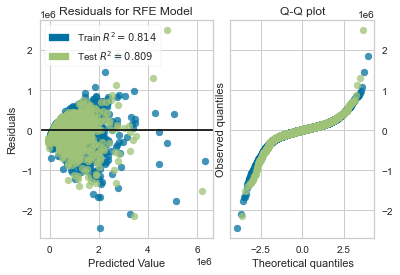

In [158]:
visualizer = ResidualsPlot(select, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

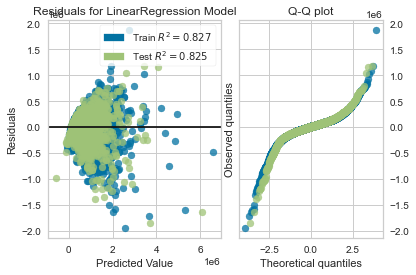

In [129]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

In [130]:
model = sm.OLS(y_train, poly_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     486.3
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:31:59   Log-Likelihood:            -2.1614e+05
No. Observations:               16197   AIC:                         4.326e+05
Df Residuals:                   16039   BIC:                         4.338e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
1                          9.283e+04   1.73e+04      5.351      0.000    5.88e+04    1.27e+05
bedrooms                   9.729e+06   3.61e+06      2.694      0.007    2.65e+06    1.68e+07
bathrooms                 -1.058e+07   6.04e+06     -1.750      0.080   -2.24e+07    1.27e+06
sqft_living               -2.451e+04   8038.369     -3.049      0.002   -4.03e+04   -8750.247
sqft_lot                    124.2577    226.709      0.548      0.584    -320.117     568.632
floors                     -4.51e+07   7.52e+06     -6.000      0.000   -5.98e+07   -3.04e+07
waterfront                 4.107e+05   2.74e+06      0.150      0.881   -4.96e+06    5.78e+06
view                       2.531e+06   3.61e+06      0.702      0.483   -4.54e+06     9.6e+06
condition                  -1.58e+06   4.19e+06     -0.378      0.706   -9.78e+06    6.62e+06
grade                     -1.673e+07   4.23e+06     -3.954      0.000    -2.5e+07   -8.44e+06
sqft_above                 6.041e+04   8137.405      7.424      0.000    4.45e+04    7.64e+04
zipcode                   -6.351e+04   2.83e+04     -2.241      0.025   -1.19e+05   -7966.699
lat                        1.146e+08    2.3e+07      4.975      0.000    6.94e+07     1.6e+08
long                      -7.778e+06   2.44e+07     -0.318      0.750   -5.57e+07    4.01e+07
sqft_living15             -1.462e+04   6891.728     -2.122      0.034   -2.81e+04   -1116.021
sqft_lot15                  162.9942    299.253      0.545      0.586    -423.574     749.563
house_age                 -2.296e+05    1.6e+05     -1.439      0.150   -5.42e+05    8.31e+04
renovated                   4.31e+07   7.17e+06      6.009      0.000     2.9e+07    5.72e+07
bedrooms^2                  771.2593    249.336      3.093      0.002     282.532    1259.986
bedrooms bathrooms         1550.7818   3472.214      0.447      0.655   -5255.146    8356.709
bedrooms sqft_living        -20.0168      4.677     -4.280      0.000     -29.185     -10.849
bedrooms sqft_lot             0.0506      0.074      0.680      0.496      -0.095       0.197
bedrooms floors            1.842e+04   4826.390      3.817      0.000    8963.160    2.79e+04
bedrooms waterfront       -4.198e+04   2.06e+04     -2.034      0.042   -8.24e+04   -1523.761
bedrooms view              2457.2966   2412.321      1.019      0.308   -2271.123    7185.716
bedrooms condition        -2469.9649   2865.700     -0.862      0.389   -8087.057    3147.127
bedrooms grade             1826.1235   2570.556      0.710      0.477   -3212.455    6864.702
bedrooms sqft_above           1.9544      5.164      0.378      0.705      -8.169      12.077
bedrooms zipcode             -7.4615     42.182     -0.177      0.860     -90.143      75.220
bedrooms lat              -2.803e+04   1.46e+04     -1.914      0.056   -5.

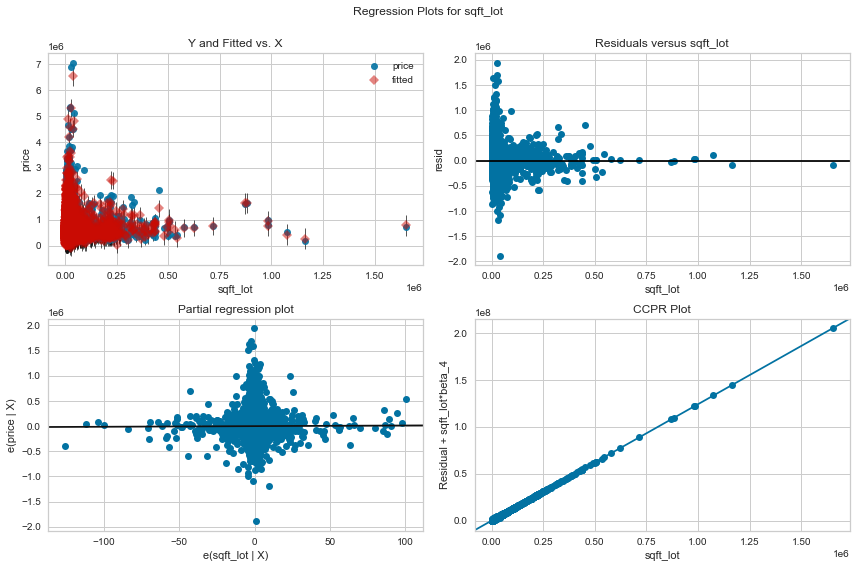

In [131]:
model.params

fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'sqft_lot', fig=fig)

In [132]:
ridge = Ridge(alpha=1.0)
ridge.fit(poly_train, y_train)
ridge.score(poly_train,y_train), ridge.score(poly_test, y_test)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.17095e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


(0.8242604720121437, 0.8228479024168502)

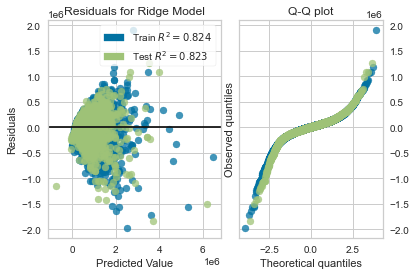

In [133]:
visualizer = ResidualsPlot(ridge, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

In [134]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [135]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns), index=X_train.index)
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns), index=X_test.index)

In [136]:
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

eval_model(X, y, poly_train, poly_test, log_y_train, log_y_test)

 Intercept: 49570.636604374566
Coefficient: [ 3.28701023e-06  2.35219407e+01 -1.17654399e+01 -4.54101732e-02
 -1.38226618e-04 -6.38706644e+01  6.84914855e+01  3.48878591e-01
 -1.77410141e+00 -1.59687751e+01  5.61953328e-02 -3.85384464e-01
  1.72699672e+02  5.67379751e+02 -6.29143580e-04 -2.61084822e-04
 -1.30629407e-01  4.29876663e+01  1.15028305e-03  2.07221137e-03
 -1.79143185e-05 -7.96386489e-08  2.67820664e-02 -9.16418919e-03
  3.35505772e-03 -8.16258963e-03  3.87465734e-03 -9.47403743e-07
 -1.71307579e-04  3.75719835e-03  5.70314885e-02  4.51488879e-06
  1.15500564e-07  6.65472991e-04 -1.75093205e-02 -3.18709237e-04
 -4.40515707e-06 -3.97585472e-07 -4.44552890e-02  1.64949491e-02
 -4.10547657e-03 -1.32161795e-02  9.70837840e-03  1.89259098e-05
  1.95420447e-04  4.54303003e-02  7.74457795e-02 -1.87863003e-05
  2.78334640e-07 -1.01686624e-04 -1.58901372e-02 -3.86762755e-08
 -1.10630616e-10  1.23153381e-05 -4.48835463e-05 -1.45698024e-05
  1.08104686e-05  9.57846909e-06  5.23284884e-

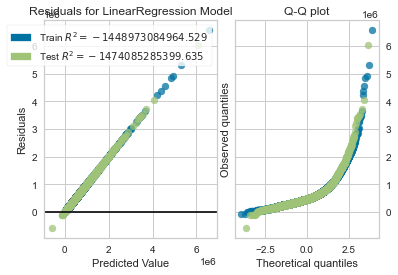

In [137]:
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(poly_train, log_y_train)
visualizer.score(poly_test, log_y_test)
visualizer.show();